In [ ]:
import random
import os
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf

### **Dataset Load**

In [ ]:
data_dir ="/content/drive/MyDrive/Colab Notebooks/Satellite Image"

In [ ]:
for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Satellite Image'.
There are 0 directories and 1500 images in '/content/drive/MyDrive/Colab Notebooks/Satellite Image/water'.
There are 0 directories and 1510 images in '/content/drive/MyDrive/Colab Notebooks/Satellite Image/cloudy'.
There are 0 directories and 1131 images in '/content/drive/MyDrive/Colab Notebooks/Satellite Image/desert'.
There are 0 directories and 1500 images in '/content/drive/MyDrive/Colab Notebooks/Satellite Image/green_area'.


In [ ]:
all_subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_names = [d for d in all_subdirs if any(fname.endswith(('.jpg', '.png', '.jpeg')) for fname in os.listdir(os.path.join(data_dir, d)))]
n_classes = len(class_names)
class_names, n_classes

(['water', 'cloudy', 'desert', 'green_area'], 4)

### Train and Test Split

In [ ]:
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Satellite Image'

# Define train and test split ratio
train_ratio = 0.8

for cls in class_names:
    # Get list of all images
    src_dir = os.path.join(data_dir, cls)
    all_files = os.listdir(src_dir)

    # Randomly shuffle the file list
    np.random.shuffle(all_files)

    # Split into training and testing sets
    train_files = all_files[:int(len(all_files)*train_ratio)]
    test_files = all_files[int(len(all_files)*train_ratio):]

    # Create train and test directories
    train_dir = os.path.join(dataset_dir, 'Train', cls)
    test_dir = os.path.join(dataset_dir, 'Test', cls)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy images into respective directories
    for file in train_files:
        shutil.copy(os.path.join(src_dir, file), train_dir)
    for file in test_files:
        shutil.copy(os.path.join(src_dir, file), test_dir)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Satellite Image/Train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Satellite Image/Test'

In [ ]:
from PIL import Image

# dir_dict = {train_dir: "Training", test_dir: "Testing"}
dir_dict = {train_dir: "Training", test_dir: "Testing"}

data = []

for type_dir, type_label in dir_dict.items():
    for class_name in class_names:
        target_folder = os.path.join(type_dir, class_name)
        for image_file in os.listdir(target_folder):
            img_path = os.path.join(target_folder, image_file)
            with Image.open(img_path) as img:
                data.append({
                    'class_name': class_name,
                    'type': type_label,
                    'img_path': img_path,
                    'shapes': img.size + (len(img.getbands()),)
                })

df = pd.DataFrame(data)

In [ ]:
df_train = df[df['type'] == 'Training']
df_test = df[df['type'] == 'Testing']

### Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data_augmented, train_data, test_data

(<keras.preprocessing.image.DirectoryIterator at 0x7d63f09754e0>,
 <keras.preprocessing.image.DirectoryIterator at 0x7d63f0975060>)

In [ ]:
import numpy as np

def is_one_hot(labels):
    return ((labels.ndim == 2) and
            (labels.shape[1] >= 2) and
            (np.all((labels == 0) | (labels == 1))) and
            (np.all(labels.sum(axis=1) == 1)))

In [ ]:
images, labels = next(iter(train_data_augmented))
labels[0:5]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
if is_one_hot(labels):
    print("Use categorical_crossentropy")
else:
    print("Use sparse_categorical_crossentropy")

Use categorical_crossentropy


### CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_classes, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_19 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_21 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history = model.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
141/141 [==============================] - 18s 125ms/step - loss: 0.5093 - accuracy: 0.7150 - val_loss: 0.4895 - val_accuracy: 0.7440
Epoch 2/5
141/141 [==============================] - 18s 124ms/step - loss: 0.4576 - accuracy: 0.7832 - val_loss: 0.3883 - val_accuracy: 0.8326
Epoch 3/5
141/141 [==============================] - 19s 138ms/step - loss: 0.3778 - accuracy: 0.8391 - val_loss: 0.3664 - val_accuracy: 0.8459
Epoch 4/5
141/141 [==============================] - 20s 141ms/step - loss: 0.3535 - accuracy: 0.8575 - val_loss: 0.3898 - val_accuracy: 0.8158
Epoch 5/5
141/141 [==============================] - 18s 131ms/step - loss: 0.3417 - accuracy: 0.8586 - val_loss: 0.3105 - val_accuracy: 0.8751


In [ ]:
model.evaluate(test_data)

36/36 [==============================] - 3s 88ms/step - loss: 0.3105 - accuracy: 0.8751


[0.3104648292064667, 0.8751107454299927]

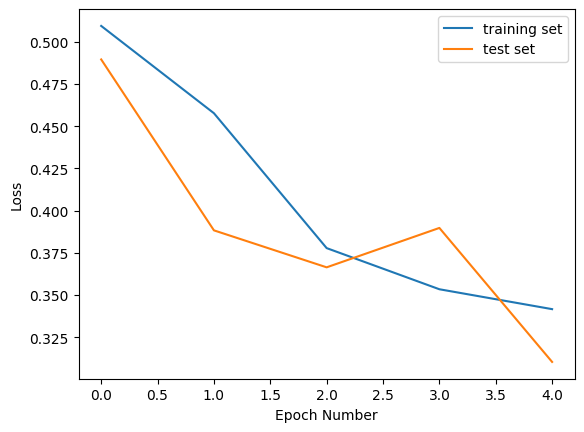

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

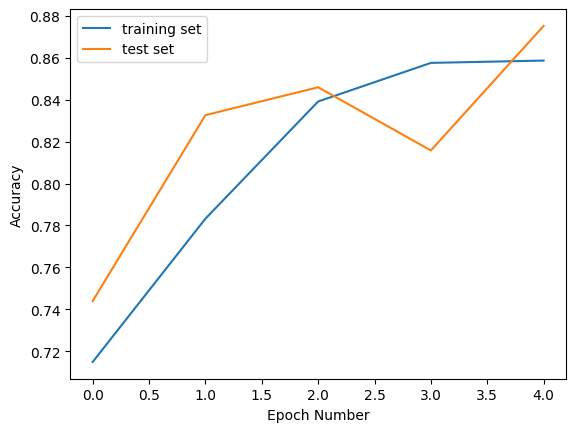

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### ResNet34 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the ResNet-34 architecture
def ResNet34(input_shape, num_classes):
    inputs = Input(shape=input_shape)


    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)




    x = GlobalAveragePooling2D()(x)


    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=x)
    return model


input_shape = (224, 224, 3)
num_classes = n_classes


model = ResNet34(input_shape, num_classes)


model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_71 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_263 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_8   (None, 64)               0   

In [ ]:
history = model.fit(
            train_data_augmented,
            epochs=5,
            verbose=1,
            validation_data=test_data
        )

Epoch 1/5
141/141 [==============================] - 102s 707ms/step - loss: 0.5518 - accuracy: 0.7633 - val_loss: 0.9329 - val_accuracy: 0.5146
Epoch 2/5
141/141 [==============================] - 75s 535ms/step - loss: 0.4580 - accuracy: 0.8191 - val_loss: 0.6438 - val_accuracy: 0.7148
Epoch 3/5
141/141 [==============================] - 73s 520ms/step - loss: 0.4153 - accuracy: 0.8324 - val_loss: 0.4628 - val_accuracy: 0.8140
Epoch 4/5
141/141 [==============================] - 71s 502ms/step - loss: 0.3987 - accuracy: 0.8391 - val_loss: 0.5305 - val_accuracy: 0.7520
Epoch 5/5
141/141 [==============================] - 73s 519ms/step - loss: 0.3941 - accuracy: 0.8429 - val_loss: 0.6098 - val_accuracy: 0.7298


In [ ]:
model.evaluate(test_data)

36/36 [==============================] - 3s 84ms/step - loss: 0.6098 - accuracy: 0.7298


[0.6098024845123291, 0.7298493981361389]

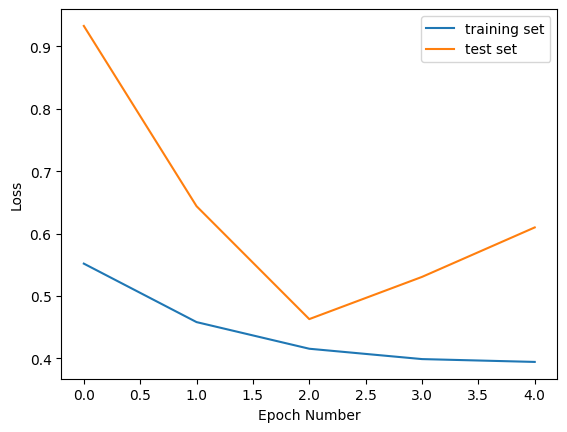

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

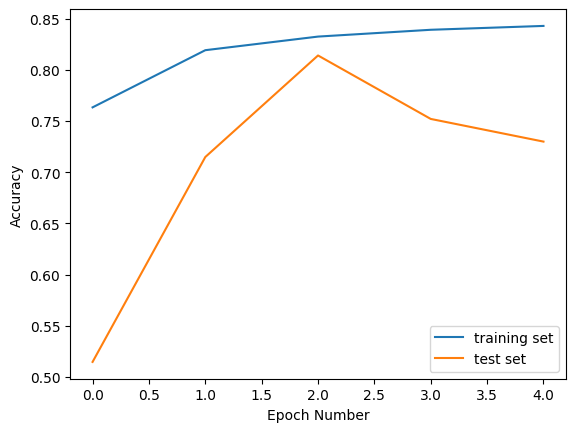

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


def VGG16(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten and Fully Connected Layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=predictions)
    return model


input_shape = (224, 224, 3)
num_classes = n_classes


model = VGG16(input_shape, num_classes)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(
            train_data_augmented,
            epochs=5,
            verbose=1,
            validation_data=test_data
        )

Epoch 1/5
141/141 [==============================] - 123s 742ms/step - loss: 1.4390 - accuracy: 0.2717 - val_loss: 1.3855 - val_accuracy: 0.2657
Epoch 2/5
141/141 [==============================] - 96s 676ms/step - loss: 1.3821 - accuracy: 0.2684 - val_loss: 1.3802 - val_accuracy: 0.2657
Epoch 3/5
141/141 [==============================] - 97s 686ms/step - loss: 1.3814 - accuracy: 0.2629 - val_loss: 1.3803 - val_accuracy: 0.2657
Epoch 4/5
141/141 [==============================] - 97s 689ms/step - loss: 1.3811 - accuracy: 0.2598 - val_loss: 1.3801 - val_accuracy: 0.2657
Epoch 5/5
141/141 [==============================] - 94s 667ms/step - loss: 1.3806 - accuracy: 0.2699 - val_loss: 1.3801 - val_accuracy: 0.2657


In [ ]:
model.evaluate(test_data)

36/36 [==============================] - 4s 119ms/step - loss: 1.3801 - accuracy: 0.2657


[1.380125641822815, 0.2657218873500824]

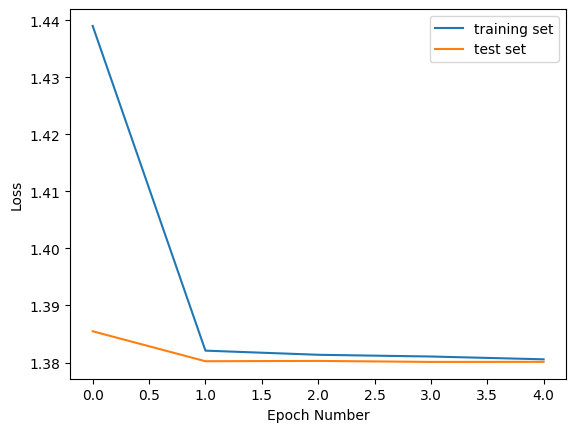

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

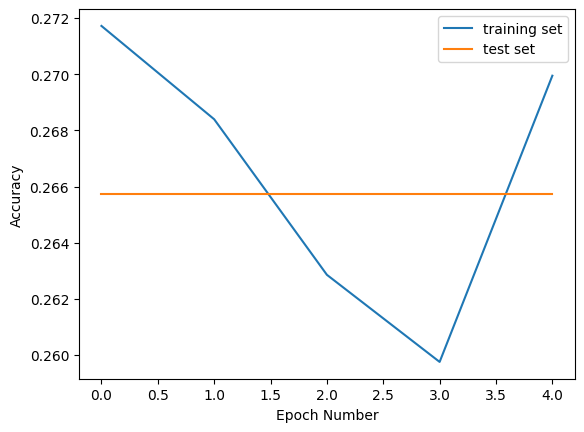

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### InceptionV3 Model


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D


def InceptionV3(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(32, (3, 3), activation='relu', padding='valid')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Inception Block 1
    tower1 = Conv2D(64, (1, 1), activation='relu')(x)
    tower1 = Conv2D(64, (3, 3), activation='relu', padding='same')(tower1)

    tower2 = Conv2D(64, (1, 1), activation='relu')(x)
    tower2 = Conv2D(64, (5, 5), activation='relu', padding='same')(tower2)

    tower3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower3 = Conv2D(64, (1, 1), activation='relu')(tower3)

    x = tf.keras.layers.concatenate([tower1, tower2, tower3], axis=-1)


    x = GlobalAveragePooling2D()(x)


    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)


    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model


input_shape = (224, 224, 3)
num_classes = n_classes


model = InceptionV3(input_shape, num_classes)

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 222, 222, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 220, 220, 32  9248        ['conv2d_94[0][0]']              
                                )                                                           

In [ ]:
history = model.fit(
            train_data_augmented,
            epochs=5,
            verbose=1,
            validation_data=test_data
        )

Epoch 1/5
141/141 [==============================] - 97s 618ms/step - loss: 0.6385 - accuracy: 0.6372 - val_loss: 0.5041 - val_accuracy: 0.6953
Epoch 2/5
141/141 [==============================] - 88s 622ms/step - loss: 0.5101 - accuracy: 0.7270 - val_loss: 0.5077 - val_accuracy: 0.7812
Epoch 3/5
141/141 [==============================] - 82s 581ms/step - loss: 0.4108 - accuracy: 0.8245 - val_loss: 0.3492 - val_accuracy: 0.8547
Epoch 4/5
141/141 [==============================] - 81s 573ms/step - loss: 0.3370 - accuracy: 0.8628 - val_loss: 0.3583 - val_accuracy: 0.8450
Epoch 5/5
141/141 [==============================] - 80s 563ms/step - loss: 0.3328 - accuracy: 0.8666 - val_loss: 0.3234 - val_accuracy: 0.8760


In [ ]:
model.evaluate(test_data)

36/36 [==============================] - 4s 95ms/step - loss: 0.3234 - accuracy: 0.8760


[0.3234030306339264, 0.875996470451355]

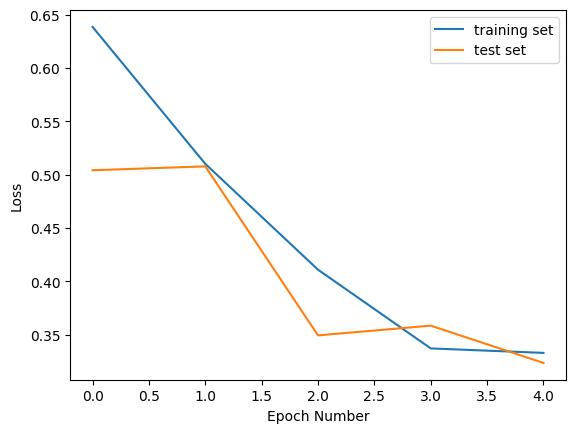

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

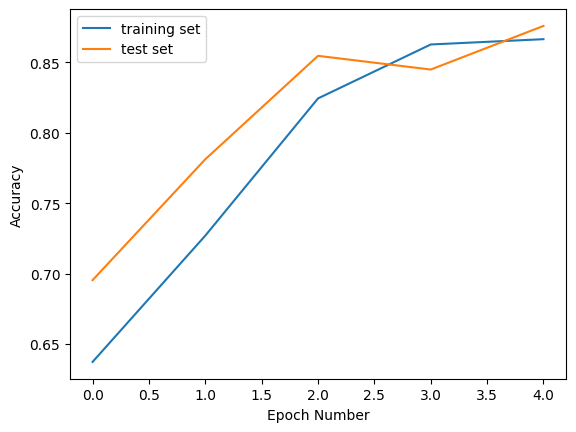

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### Transfer Learning Approach


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


input_shape = (224, 224, 3)
num_classes = n_classes


base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)


for layer in base_model.layers:
    layer.trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
history = model.fit(
    train_data_augmented,
    epochs=5,
    validation_data=test_data,
)

Epoch 1/5
141/141 [==============================] - 80s 555ms/step - loss: 1.0509 - accuracy: 0.5891 - val_loss: 0.6532 - val_accuracy: 0.9637
Epoch 2/5
141/141 [==============================] - 76s 539ms/step - loss: 0.4928 - accuracy: 0.8717 - val_loss: 0.3510 - val_accuracy: 0.9539
Epoch 3/5
141/141 [==============================] - 77s 544ms/step - loss: 0.2825 - accuracy: 0.9391 - val_loss: 0.2750 - val_accuracy: 0.8999
Epoch 4/5
141/141 [==============================] - 78s 554ms/step - loss: 0.2110 - accuracy: 0.9410 - val_loss: 0.2432 - val_accuracy: 0.9194
Epoch 5/5
141/141 [==============================] - 76s 542ms/step - loss: 0.1823 - accuracy: 0.9428 - val_loss: 0.2673 - val_accuracy: 0.8946


In [ ]:
model.evaluate(test_data)

36/36 [==============================] - 5s 141ms/step - loss: 0.2673 - accuracy: 0.8946


[0.2673444449901581, 0.8945969939231873]

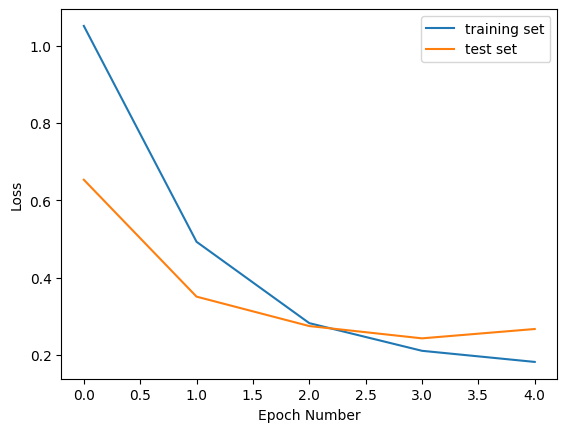

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

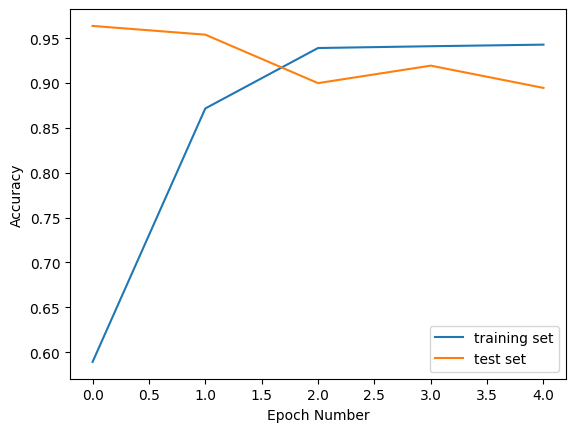

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()